In [1]:
# Importing
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torchmetrics import Accuracy
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary

In [2]:
# Random Seed
RANDOM_SEED = 42
# Setting Device
device = "cpu" if torch.cuda.is_available else "cpu"
print(device)

cpu


In [3]:
# Creating Samples
N_SAMPLES = 1000
X, y = make_moons(N_SAMPLES,
                noise=0.05,
                random_state=RANDOM_SEED)
print(X[:5], y[:5])

[[-0.02137124  0.40618608]
 [ 0.97670045 -0.45832306]
 [ 0.90405882 -0.37651952]
 [ 0.37736316 -0.39703717]
 [-0.84192557  0.53058695]] [1 1 1 1 0]


In [4]:
# Cleaning Data Layout
moons = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "Label": y
})

moons[:5]

,X1,X2,Label
0,-0.021371,0.406186,1
1,0.976700,-0.458323,1
2,0.904059,-0.376520,1
3,0.377363,-0.397037,1
4,-0.841926,0.530587,0


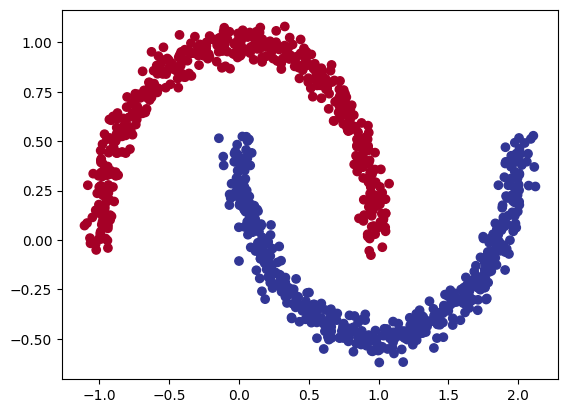

In [5]:
# Visualizing Data
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu
           )

In [6]:
# Converting Numpy Arrays to Tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
# Splitting Data - Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
print(len(X_train), len(X_test), len(y_train), len(y_test))

800 200 800 200


In [7]:
# Building Model
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

model0 = MoonModelV0().to(device)
print(model0)

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [8]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(model0.parameters(), lr=0.1)
acc_fn = Accuracy(task='multiclass', num_classes=4).to(device)

In [9]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

800 200 800 200


In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [11]:
torch.manual_seed(42) 
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model0.train()

    train_logits = model0(X_train).squeeze()
    train_preds = torch.round(torch.sigmoid(train_logits))
    
    loss = loss_fn(train_logits, y_train)
    acc = acc_fn(train_preds, y_train)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    model0.eval()
    with torch.inference_mode():
        test_logits = model0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_preds, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}% ")

Epoch: 0 | Loss: 0.69480 | Accuracy: 0.50% | Test Loss: 0.69323 | Test Accuracy: 0.50% 
Epoch: 100 | Loss: 0.31504 | Accuracy: 0.88% | Test Loss: 0.32118 | Test Accuracy: 0.89% 
Epoch: 200 | Loss: 0.15751 | Accuracy: 0.94% | Test Loss: 0.15420 | Test Accuracy: 0.93% 
Epoch: 300 | Loss: 0.06860 | Accuracy: 0.98% | Test Loss: 0.06336 | Test Accuracy: 0.99% 
Epoch: 400 | Loss: 0.02328 | Accuracy: 1.00% | Test Loss: 0.02107 | Test Accuracy: 1.00% 
Epoch: 500 | Loss: 0.01104 | Accuracy: 1.00% | Test Loss: 0.00984 | Test Accuracy: 1.00% 
Epoch: 600 | Loss: 0.00670 | Accuracy: 1.00% | Test Loss: 0.00592 | Test Accuracy: 1.00% 
Epoch: 700 | Loss: 0.00465 | Accuracy: 1.00% | Test Loss: 0.00408 | Test Accuracy: 1.00% 
Epoch: 800 | Loss: 0.00350 | Accuracy: 1.00% | Test Loss: 0.00306 | Test Accuracy: 1.00% 
Epoch: 900 | Loss: 0.00277 | Accuracy: 1.00% | Test Loss: 0.00241 | Test Accuracy: 1.00% 


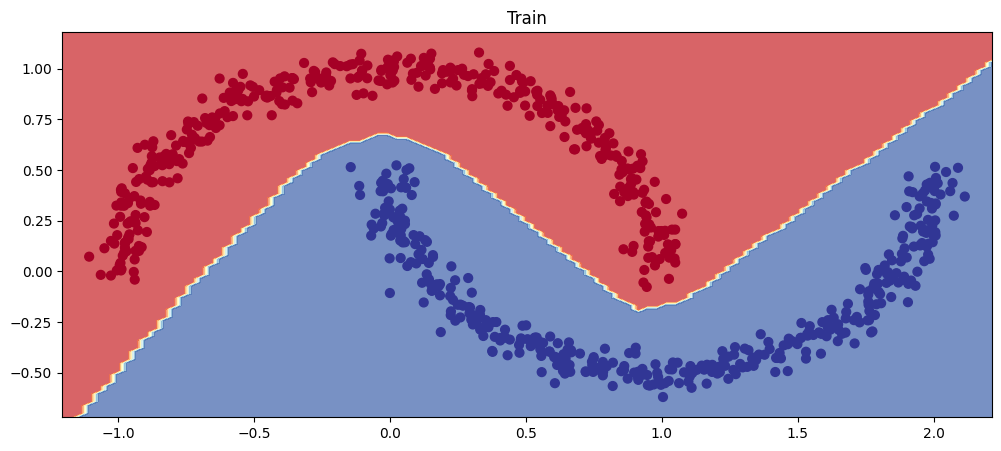

In [12]:
plt.figure(figsize=(12,5))
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)

In [13]:
model0.eval()
with torch.inference_mode():
    test_preds = torch.round(torch.sigmoid(test_logits))

In [14]:
# Plot the model predictions
import numpy as np

def cs_plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [15]:
start = -10
end = 10
step = 1

line = torch.arange(start, end, step, dtype=torch.float32)
line

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

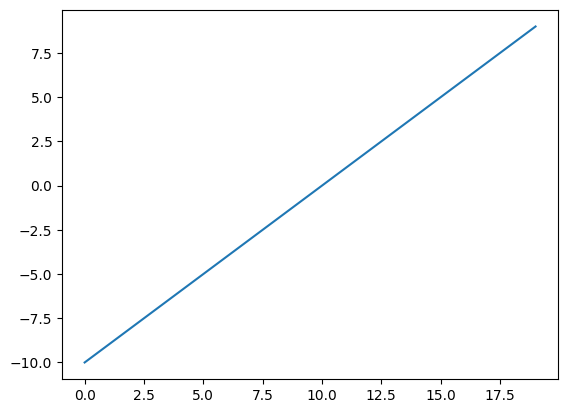

In [16]:
plt.plot(line)

In [17]:
def tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def relu(x):
    return torch.maximum(torch.tensor(0), x)

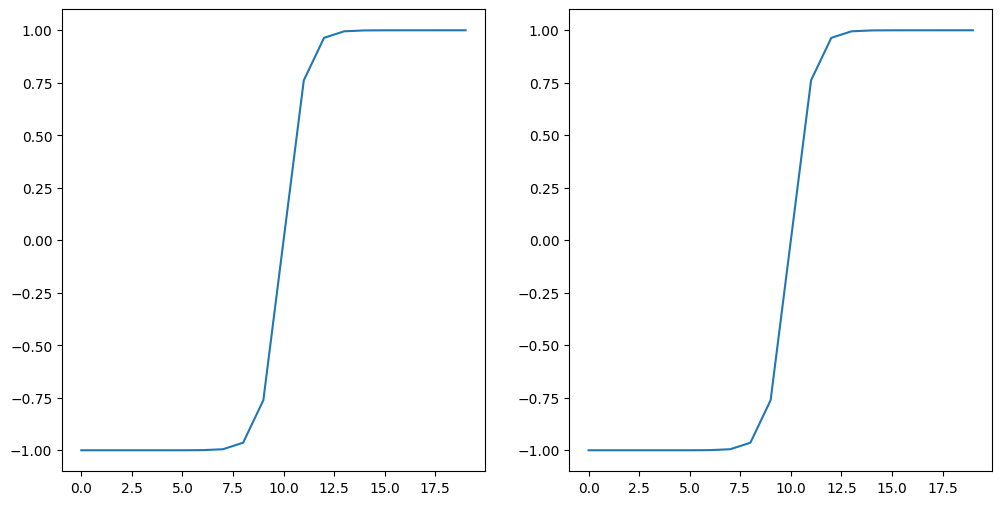

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tanh(line))
plt.subplot(1,2,2)
plt.plot(torch.tanh(line))

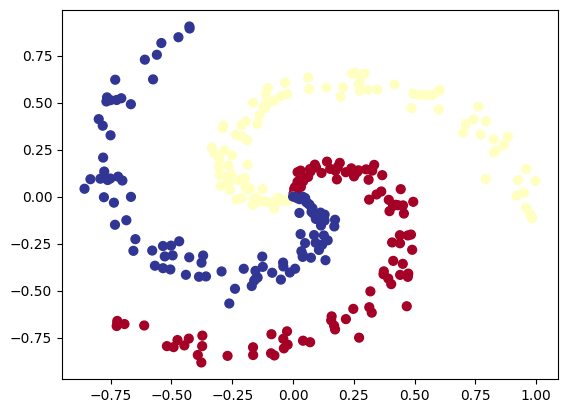

In [19]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
    
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()
     

In [20]:
class SpiralModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20,4),
            nn.ReLU()
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model1 = SpiralModelV0()
model1

SpiralModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=4, bias=True)
    (7): ReLU()
  )
)

In [21]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

240 60 240 60


In [23]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model1.parameters(), lr=0.1)
acc_fn = Accuracy(task='multiclass', num_classes=4).to(device)

In [24]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model1.train()

    train_logits = model1(X_train)
    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

    loss = loss_fn(train_logits, y_train)
    acc = acc_fn(train_logits, y_train)

    optim.zero_grad()
    loss.backward()
    optim.step()

    model1.eval()
    with torch.inference_mode():
        test_logits = model1(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_logits, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}% ")

Epoch: 0 | Loss: 1.43691 | Accuracy: 0.00% | Test Loss: 1.41554 | Test Accuracy: 0.00% 
Epoch: 100 | Loss: 1.30021 | Accuracy: 0.47% | Test Loss: 1.24813 | Test Accuracy: 0.48% 
Epoch: 200 | Loss: 0.98291 | Accuracy: 0.57% | Test Loss: 0.94950 | Test Accuracy: 0.55% 
Epoch: 300 | Loss: 0.63971 | Accuracy: 0.60% | Test Loss: 0.64923 | Test Accuracy: 0.57% 
Epoch: 400 | Loss: 0.51272 | Accuracy: 0.70% | Test Loss: 0.50859 | Test Accuracy: 0.73% 
Epoch: 500 | Loss: 0.36141 | Accuracy: 0.87% | Test Loss: 0.34712 | Test Accuracy: 0.87% 
Epoch: 600 | Loss: 0.23119 | Accuracy: 0.92% | Test Loss: 0.21277 | Test Accuracy: 0.90% 
Epoch: 700 | Loss: 0.15978 | Accuracy: 0.93% | Test Loss: 0.12712 | Test Accuracy: 0.98% 
Epoch: 800 | Loss: 0.11576 | Accuracy: 0.96% | Test Loss: 0.07952 | Test Accuracy: 0.98% 
Epoch: 900 | Loss: 0.08898 | Accuracy: 0.97% | Test Loss: 0.05515 | Test Accuracy: 0.98% 


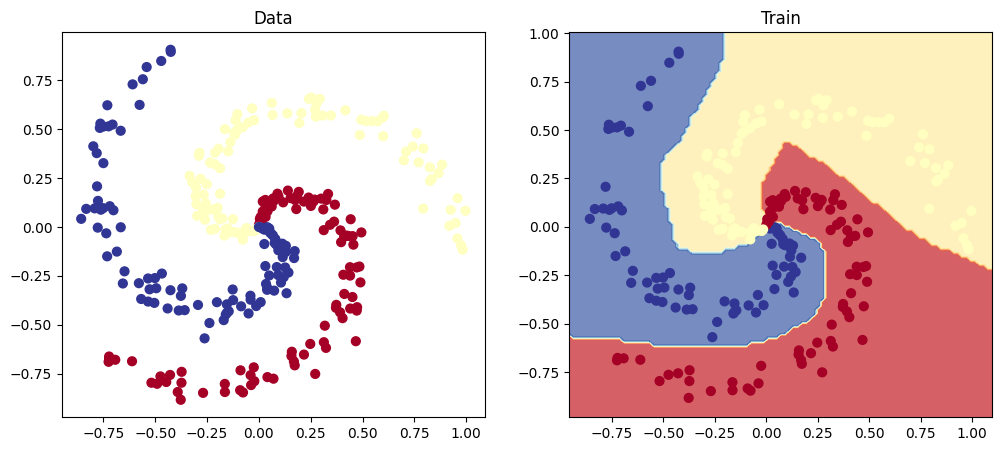

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.subplot(1, 2, 2)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)

ANSWERS: 

**Precision** is MAKING SURE that all predictions are correct. Meaning that we're more focused on finding if there is something wrong that slipped through. Akin to a customs inspection trying to check each package that were labelled as contraband and illegal as actually that. We are making sure that the positives/goods that we are letting through are indeed what they say they are. We are double-checking already flagged items. 

High precision means high confidence on positives, but we have no guarantee that we have accounted for all positives because we were too busy double-checking each one. In addition, we don't really care much about positives that were incorrectly labelled as negatives. (False Positive > False Negative)

**Recall** is MAKING SURE that all positive/correnct instances are accounted for. This is akin to a loving and caring professor conducting a roll call of a classroom to ensure that all the students are inside the class and not paying any mind to other students who are also inside to but are not part of the class. 

High recall means that we are making sure that all positives are accounted for, even if some of these positives might be wrong or from another class. (False Negative > False Positive)

NOTES FOR MIT - Introduction to Deep Learning

